---
# Анализ извеченных сущностей

> **🎯 Цель этого ноутбука:** выполнить базовый анализ извлеченных сущностей, посмотреть на самые популярные в каждой категории.
---

## Импорт библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Анализ

In [18]:
df = pd.read_csv('../data/final_ent.csv', parse_dates=['date'])

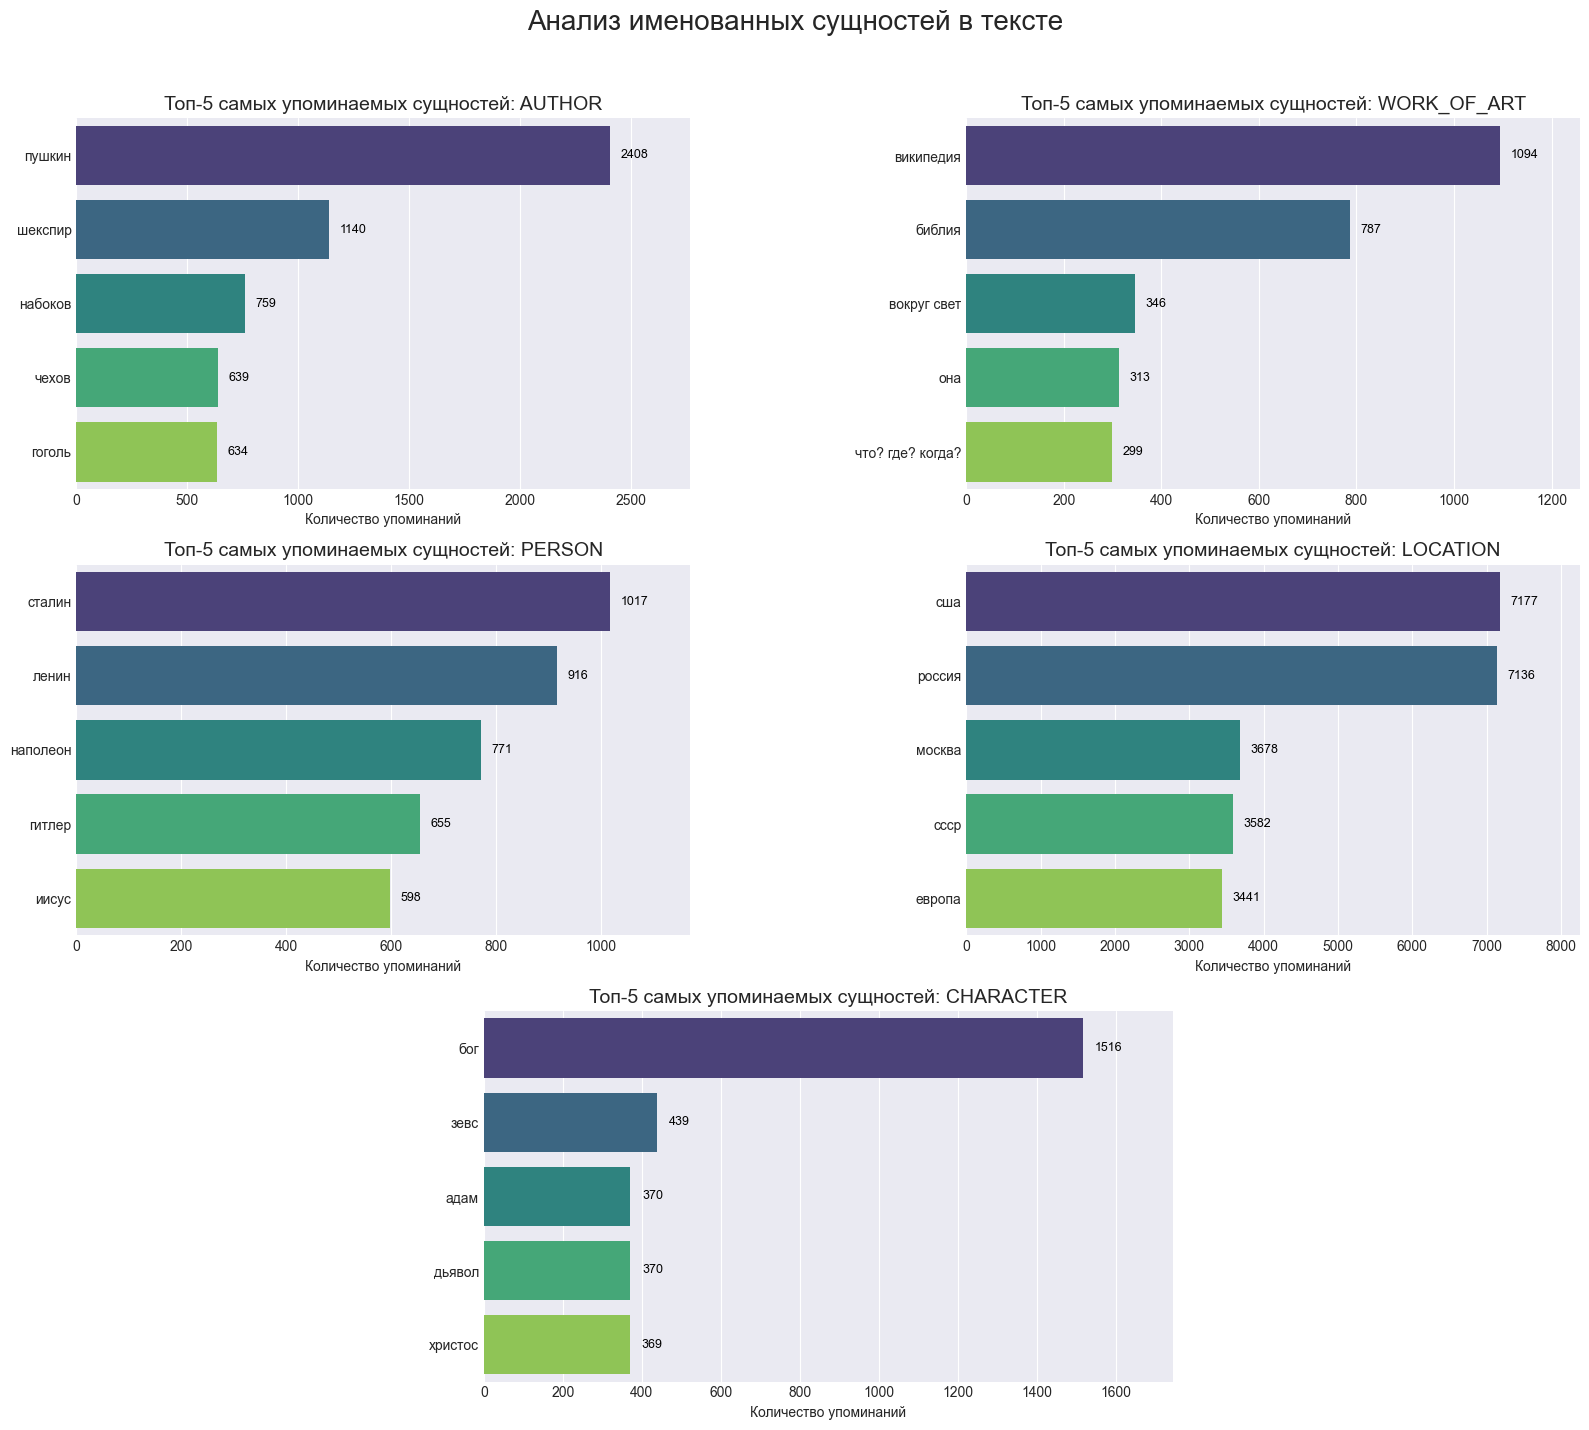

In [ ]:
def plot_top_n_on_ax(ax, df, entity_type, n=5):

    top_entities = df[df['entity_group'] == entity_type]['word'].value_counts().nlargest(n)
    if top_entities.empty:
        ax.text(0.5, 0.5, f'Нет данных для\n{entity_type}', 
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, style='italic')
        ax.set_title(f'Топ-{n} сущностей: {entity_type}', fontsize=14)
        ax.set_xticks([]); ax.set_yticks([])
        return

    sns.barplot(x=top_entities.values, y=top_entities.index, 
                hue=top_entities.index, palette='viridis', legend=False, ax=ax)
    
    ax.set_title(f'Топ-{n} самых упоминаемых сущностей: {entity_type}', fontsize=14)
    ax.set_xlabel('Количество упоминаний', fontsize=10)
    ax.set_ylabel('')
    
    ax.set_xlim(0, top_entities.values[0] * 1.15)
    for i, v in enumerate(top_entities.values):
        ax.text(v + (top_entities.values[0] * 0.02), i, str(v), color='black', va='center', fontsize=9)


entity_types = ['AUTHOR', 'WORK_OF_ART', 'PERSON', 'LOCATION', 'CHARACTER']
n_entities = len(entity_types)

nrows, ncols = 3, 2
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 15))
fig.suptitle('Анализ именованных сущностей в тексте', fontsize=20)

axes_flat = axes.flatten()
for i in range(4):
    if i < n_entities:
        plot_top_n_on_ax(axes_flat[i], df, entity_types[i], n=5)

axes_flat[4].axis('off')
axes_flat[5].axis('off')

if n_entities >= 5:
    ax_centered = fig.add_subplot(3, 4, (10, 11)) 
    plot_top_n_on_ax(ax_centered, df, entity_types[4], n=5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


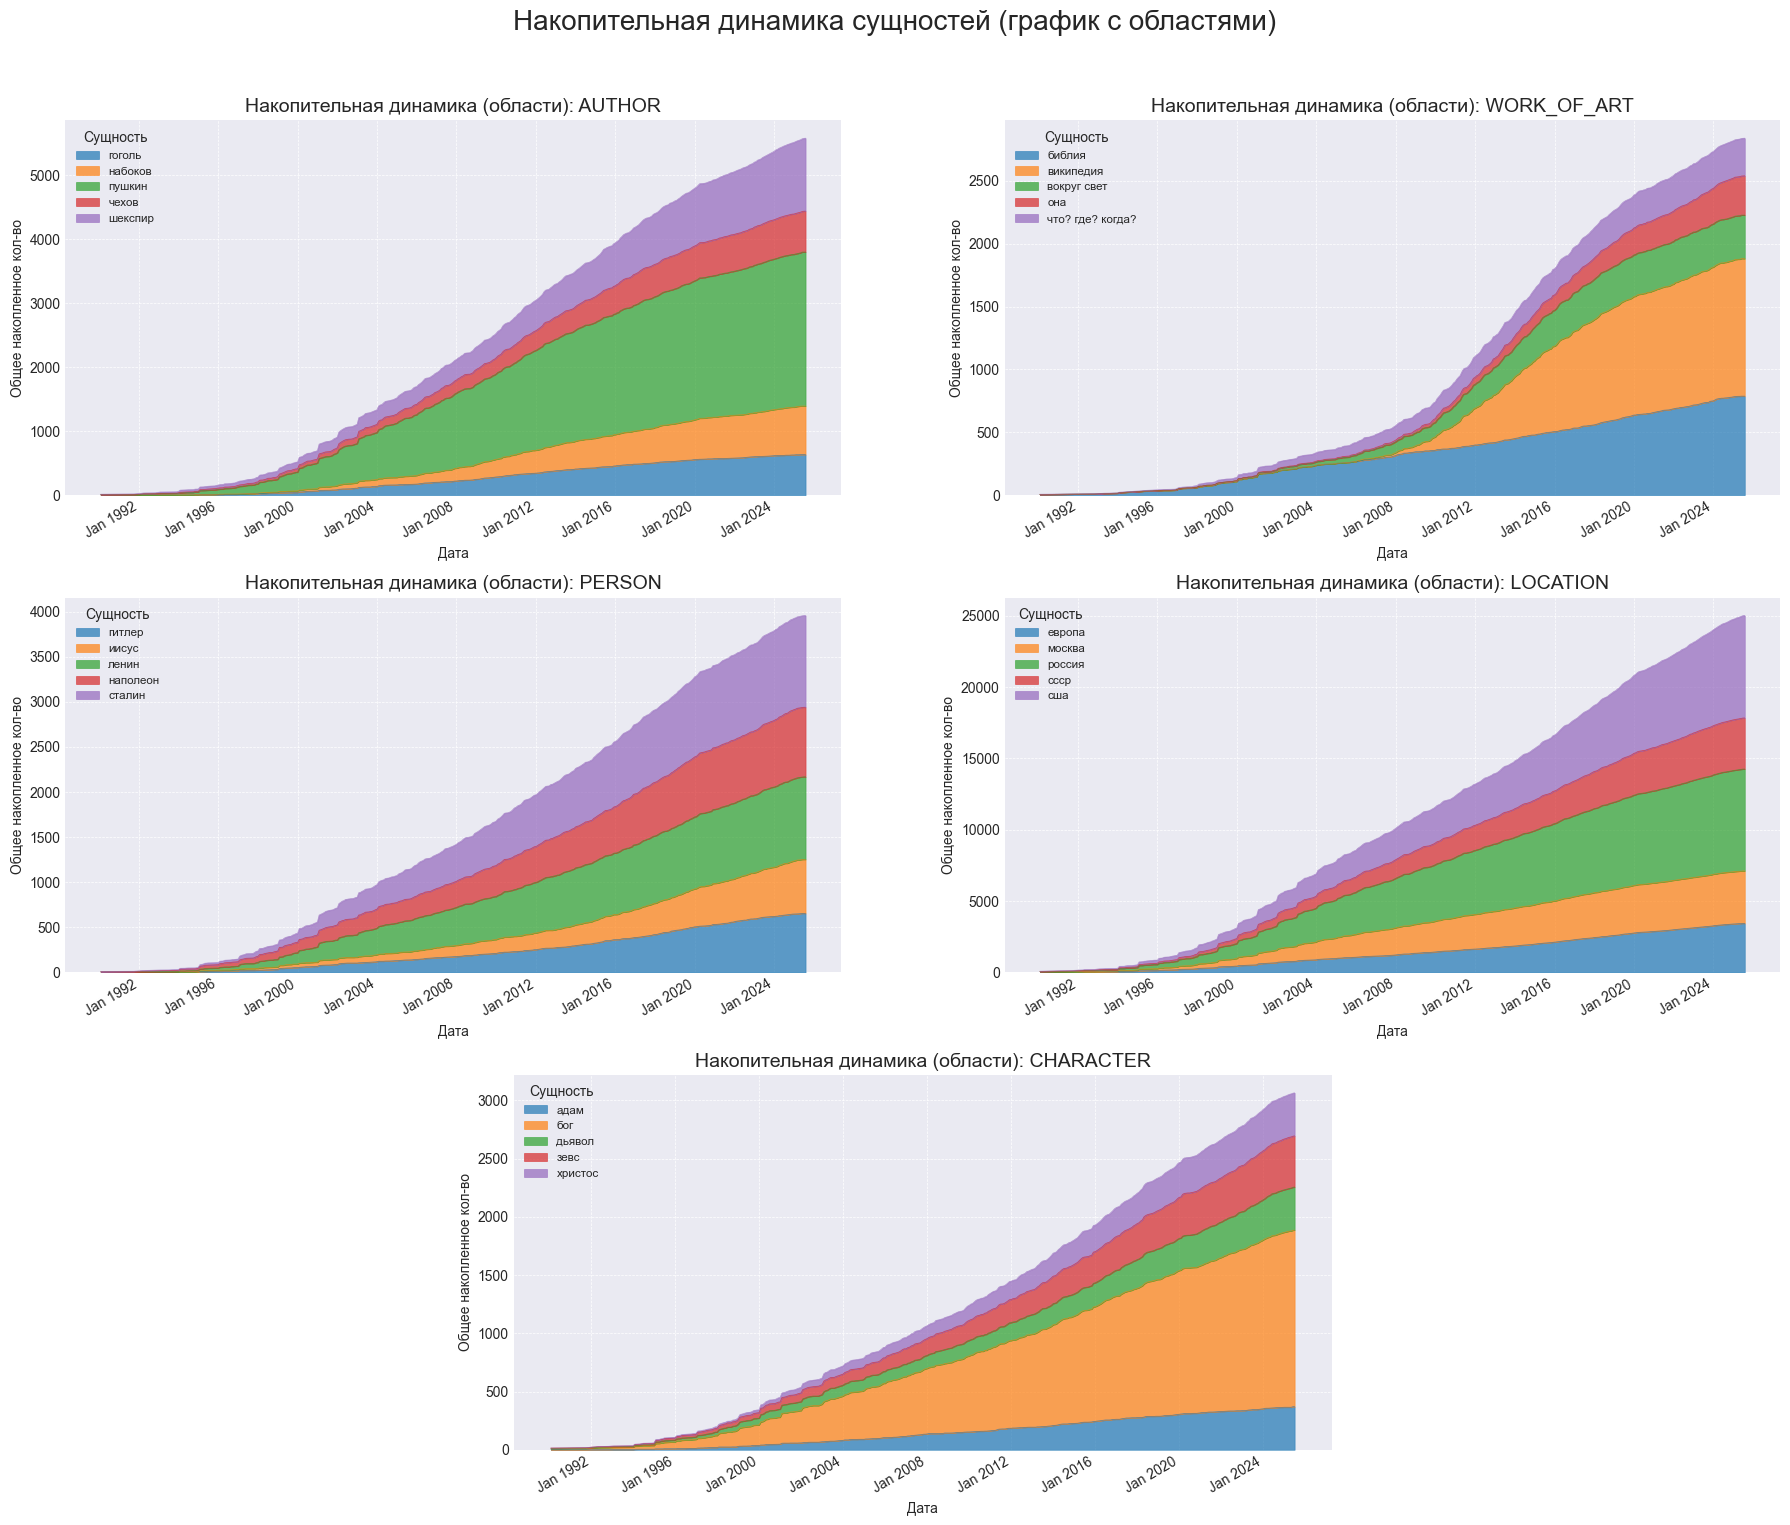

In [ ]:
def plot_cumulative_area_chart(ax, df, entity_type, n=5):

    ax.set_title(f'Накопительная динамика (области): {entity_type}', fontsize=14)
    df_filtered = df[df['entity_group'] == entity_type]
    
    if df_filtered.empty:
        ax.text(0.5, 0.5, f'Нет данных для\n{entity_type}', 
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, style='italic')
        ax.set_xticks([]); ax.set_yticks([])
        return

    top_entities = df_filtered['word'].value_counts().nlargest(n).index
    df_top = df_filtered[df_filtered['word'].isin(top_entities)].copy()
    
    time_series = df_top.set_index('date').groupby([pd.Grouper(freq='ME'), 'word']).size()
    plot_data = time_series.unstack(level='word').fillna(0)

    if plot_data.empty:
        ax.text(0.5, 0.5, f'Недостаточно данных\nдля построения динамики', 
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, style='italic')
        return

    cumulative_plot_data = plot_data.cumsum()
    cumulative_plot_data.plot(kind='area', stacked=True, ax=ax, alpha=0.7, linewidth=0.5)
    
    ax.set_xlabel('Дата', fontsize=10)
    ax.set_ylabel('Общее накопленное кол-во', fontsize=10)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend(title='Сущность', fontsize='small')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")


entity_types = ['AUTHOR', 'WORK_OF_ART', 'PERSON', 'LOCATION', 'CHARACTER']
n_entities = len(entity_types)

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
fig.suptitle('Накопительная динамика сущностей (график с областями)', fontsize=20)

axes_flat = axes.flatten()

for i in range(4):
    if i < n_entities:
        plot_cumulative_area_chart(axes_flat[i], df, entity_types[i], n=5)

axes_flat[4].axis('off')
axes_flat[5].axis('off')

if n_entities >= 5:
    ax_centered = fig.add_subplot(3, 4, (10, 11)) 
    plot_cumulative_area_chart(ax_centered, df, entity_types[4], n=5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


## Ключевые выводы

Анализ извлеченных сущностей позволяет составить "портрет" среднестатистического вопроса "Что? Где? Когда?" и выявить его ключевые культурные и исторические маркеры.

*   **Литературоцентричность:** Безоговорочным лидером среди авторов является **А.С. Пушкин**, упоминаемый более чем в два раза чаще Шекспира. В топ также входят классики русской литературы — Набоков, Чехов и Гоголь. Это подчеркивает фундаментальную роль классической, в первую очередь русской, литературы в игре.

*   **Исторический фокус:** Среди персоналий доминируют ключевые фигуры советской и мировой истории (**Сталин, Ленин, Наполеон**). Высокая частотность упоминания **СССР** как локации также подтверждает, что значительная часть вопросов так или иначе связана с историческим контекстом XX века.

*   **Библейские и мифологические сюжеты:** Сущность **"Бог"** является абсолютным лидером в категории `CHARACTER`, многократно опережая остальных. Вместе с частым упоминанием **Библии**, **Иисуса**, **Адама** и **Дьявола**, это указывает на то, что религиозные тексты и сюжеты являются одним из важнейших источников для вопросов. Вторым по значимости пластом является античная мифология (**Зевс**).

*   **Географический баланс:** В вопросах наблюдается паритет между упоминаниями **России** и **США**, что говорит о широком географическом охвате. При этом **Москва** является самой упоминаемой городской локацией, что естественно для русскоязычной игры.

*   **Эволюция источников:** График динамики показывает, что упоминания **"Википедии"** как произведения (`WORK_OF_ART`) начали резко расти с середины 2000-х годов, что отражает изменение источников информации и появление вопросов, связанных с интернет-культурой.

*   **Стабильность "вечных тем":** Динамика упоминаний показывает, что лидеры в своих категориях (Пушкин, Бог, Сталин/Ленин) сохраняли свою популярность на протяжении всей истории игры с 1990-х годов. Их доминирование не является недавним трендом, а составляет основу "культурного кода" ЧГК.
